<a href="https://colab.research.google.com/github/Giuseppe31-s/Geracao-Tech-Unimed-BH-Ciencia-de-Dados/blob/main/Machine_Learning/gatos_vs_cachorros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gatos versus cachorros

Esse notebook tem como objetivo criar um calssificador de imagens para indetificar se na foto se encontra um gato ou cachorro



In [ ]:
#Bibliotecas
import matplotlib.pyplot as plt
import requests, zipfile, io
import os
import numpy as np
import pandas as pd 
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
import random
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
import shutil
from tensorflow import keras
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [ ]:
#Valores padrões
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

#Dados

Os dados se encontram nesse endereço [dados disponíveis](https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765). Os dados consistem em um conjunto de 25000 fotos entre cachorros e gatos.

O primeiro passo nos nosso dados é juntar as fotos dos gatos e cachorros, pois estã em pastas diferentes, uma vez feita essa operação colocar o nome para indetificar se a foto se trata de cachorro ou gato. Nessa etapa foram misturados comenandos linux e python para conseguir essa tarefa de maneira eficiênte.

In [ ]:
!unzip /content/drive/MyDrive/kagglecatsanddogs_5340.zip

In [ ]:
path = '/content/PetImages'

In [ ]:
!mkdir catsanddogs

In [ ]:

filenames =  os.listdir(path)
for i in filenames:
  for file in os.listdir(f'{path}/{i}'):
    oldName = os.path.join(f'{path}/{i}', file)
    if 'jpg' in oldName:
              n = os.path.splitext(file)[0]
              b = i+'.'+ n + '.jpg'
              newName = os.path.join(f'{path}/{i}', b)

              # Renomeando arquivos
              os.rename(oldName, newName)
    else:
      continue

In [ ]:
#Movendo os arquivos
import shutil

for i in filenames:
  for file in os.listdir(f'{path}/{i}'):

      if file.split()[-1] == 'jpg':

        new_path = '/content/catsanddogs/' + file
        shutil.move(f'{path}/{i}/{file}', new_path)

      else:

        continue


Identificando se há arquivos diferentes além das fotos que são o alvo.

In [ ]:
for file in os.listdir('/content/catsanddogs'):
  if file.split('.')[-1] != 'jpg':
    print(file)
  else:
    continue

Evitando que os arquivos .db entrem na nossa pasta

In [ ]:


for i in filenames:
  for file in os.listdir(f'{path}/{i}'):

      if file.split('.')[-1] == 'jpg':

        new_path = '/content/catsanddogs/' + file
        shutil.move(f'{path}/{i}/{file}', new_path)

      else:

        continue

### Criando nosso dataframe com os nomes dos arquivos e classificando se é cachorro ou gato

In [ ]:
filenames = os.listdir("/content/catsanddogs")

categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df

,filename,category
0,Dog.12304.jpg,1
1,Cat.2632.jpg,0
2,Cat.11589.jpg,0
3,Dog.12397.jpg,1
4,Cat.386.jpg,0
...,...,...
24995,Cat.3850.jpg,0
24996,Cat.2105.jpg,0
24997,Cat.2404.jpg,0
24998,Cat.2602.jpg,0


In [ ]:
df['category'] = df['category'].map({0:'Cat',1:'Dog'})

In [ ]:
df[~df['filename'].str.contains('jpg')]

,filename,category


Visualizando a proporção entre gatos e cachorros, estão perfeitamente proporcionais, então não precisamos fazer nada nesse sentido.

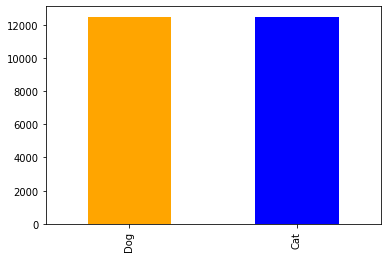

In [ ]:
df['category'].value_counts().plot.bar( color = ['orange','b'])

Verificando se no dataframe há arquivos além das imagens

In [ ]:
df.drop(df[~df['filename'].str.contains('jpg')].index,inplace = True)

In [ ]:
df.reset_index(drop = True, inplace = True)

Visualizando as nossas imagens para verificar se realmente foram classificadas de maneira correta

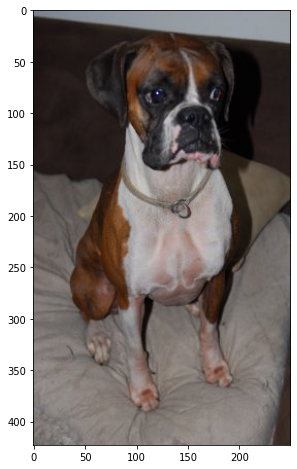

In [ ]:

sample = random.choice(df.loc[df.category == 'Dog','filename'].values)
image = load_img(f'/content/catsanddogs/{sample}')
plt.figure(figsize = (12,8))
plt.imshow(image);



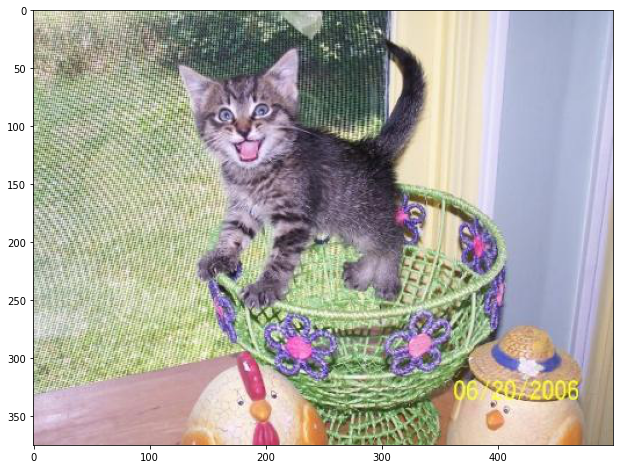

In [ ]:
sample = random.choice(df.loc[df.category == 'Cat','filename'].values)
image = load_img(f'/content/catsanddogs/{sample}')
plt.figure(figsize = (12,8))
plt.imshow(image);


#Aplicando alterações aleatórias para evitar o overtfiting

rescalando as imagens

Além das próprias imagens, as vezes, para o nosso modelo ficar mais generalista é preciso adicionar variáveis aleatórias. Nesse caso vou adicionar algumas variáveis aleatórias como luminosidade da foto, rotação da imagem, zoom, aumentando distorção de ângulo e etc.

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=7,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)


#Separando os dados para treino e teste

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
test_df

,filename,category
0,Cat.12005.jpg,Cat
1,Cat.2821.jpg,Cat
2,Cat.1138.jpg,Cat
3,Cat.3031.jpg,Cat
4,Dog.5958.jpg,Dog
...,...,...
4995,Dog.10285.jpg,Dog
4996,Dog.5953.jpg,Dog
4997,Cat.7496.jpg,Cat
4998,Dog.861.jpg,Dog


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  20000 non-null  object
 1   category  20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


###Visualizando as alterações aleatórias

Como pode ser observado nas imagens alteradas há aproximação, rotação de imagens, luminosidade e etc.



Found 20000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.


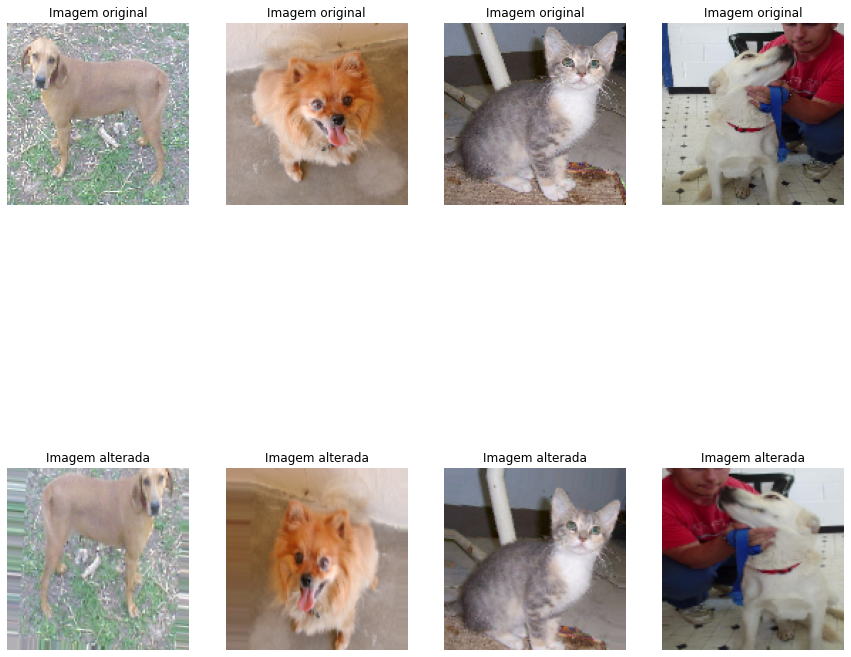

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
                  train_df,
                  "/content/catsanddogs/",
                  x_col='filename',
                  y_col='category',
                  target_size=IMAGE_SIZE, # padronizando todas as imagens
                  color_mode="rgb", # imagem colorida
                  batch_size=1, # numero de imagens extraída por batch
                  class_mode="categorical", # classes
                  seed= 2020 # para que os resultados sejam reproduzidos
                  )


datanormal = ImageDataGenerator()
# Conjunto sem sofrer alterações 
treino_normal = datanormal.flow_from_dataframe(
                  train_df,
                  "/content/catsanddogs/",
                  x_col='filename',
                  y_col='category',
                  target_size=IMAGE_SIZE, # padronizando todas as imagens
                  color_mode="rgb", # imagem colorida
                  batch_size=1, # numero de imagens extraída por batch
                  class_mode="categorical", # classes
                  seed= 2020 # para que os resultados sejam reproduzidos
                  )

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,15))

for i in range(4):

  # convertendo a imagem para inteiro
  image = next(train_generator)[0]
  image2 = next(treino_normal)[0].astype('uint8')

  # alterando o formato (1, 200, 200, 3) para (200, 200, 3) para plotar a imagem
  image = image.squeeze()
  image2 = image2.squeeze()


  # plotando as imagens
  ax[0,i].imshow(image2)
  ax[0,i].set_title('Imagem original')
  ax[0,i].axis('off')
  ax[1,i].imshow(image)
  ax[1,i].set_title('Imagem alterada')
  ax[1,i].axis('off')
                  

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
                  train_df.drop(10274),
                  "/content/catsanddogs/",
                  x_col='filename',
                  y_col='category',
                  target_size=(128,128), # padronizando todas as imagens
                  batch_size=1, # numero de imagens extraída por batch
                  )


Found 19999 validated image filenames belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
                  test_df,
                  "/content/catsanddogs/",
                  x_col='filename',
                  y_col='category',
                  target_size=(128,128), # padronizando todas as imagens
                  color_mode="rgb", # imagem colorida
                  batch_size=1, # numero de imagens extraída por batch
                  )

Found 5000 validated image filenames belonging to 2 classes.


#Rede neural pré-treinada

Carregando um modelo pré-treinado com centensa de layers já ajustadas.
modelo [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function)

In [ ]:

# Carregando o modelo base MobileNetV2.
modelo_base = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,
                                               input_shape = (128,128,3))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
#Fixando as camadas
for layer in modelo_base.layers:
  layer.trainable = False

Adicionando camadas para que a saida so nosso modelo pré-treinado seja de apenas dois valores (0,1)

In [ ]:


head_model = modelo_base.output
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(2, activation = 'softmax')(head_model)
     


In [ ]:

# Agora literalmente realizando a ligação entre o modelo base e as camadas que foram implementadas.
network = Model(inputs = modelo_base.input, outputs = head_model)
     

In [ ]:

# compilando o modelo.
network.compile(loss = 'categorical_crossentropy', optimizer='Adam', 
                metrics = ['accuracy'])
     


In [ ]:
optimizer = keras.optimizers.SGD(lr = 0.01, momentum = 0.9, decay = 0.0001)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# compilador do modelo.
network.compile(loss = 'categorical_crossentropy', optimizer= optimizer, 
                metrics = ['accuracy'])

# Ao tentar treinar o modelo, percebi que tinham algumas imagens corrompidas

Caçando arquivos corrompidos de 1 a 1, com o batch_size de 1, ao perceber que o número de arquivos corrompidos era maior que o esperado, utilizei um método para encontrar os arquivos corrompidos

## Solução:

In [ ]:
    num_skipped = 0
    for fname in os.listdir('/content/catsanddogs'):
        fpath = os.path.join('/content/catsanddogs', fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [ ]:
filenames = os.listdir("/content/catsanddogs")

categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.shape

(23410, 2)

In [ ]:
df['category'] = df['category'].map({0:'Cat',1:'Dog'})


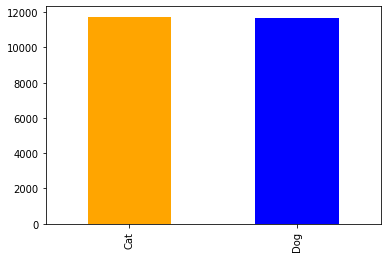

In [ ]:
df['category'].value_counts().plot.bar( color = ['orange','b'])

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
train_df

,filename,category
0,Dog.10426.jpg,Dog
1,Dog.9358.jpg,Dog
2,Cat.11157.jpg,Cat
3,Cat.12447.jpg,Cat
4,Cat.11873.jpg,Cat
...,...,...
18723,Dog.6960.jpg,Dog
18724,Cat.11968.jpg,Cat
18725,Cat.9703.jpg,Cat
18726,Dog.5329.jpg,Dog


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=7,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
                  train_df,
                  "/content/catsanddogs/",
                  x_col='filename',
                  y_col='category',
                  target_size=(128,128), # padronizando todas as imagens
                  batch_size=15, # numero de imagens extraída por batch
                  )

Found 18728 validated image filenames belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = test_datagen.flow_from_dataframe(
                  test_df,
                  "/content/catsanddogs/",
                  x_col='filename',
                  y_col='category',
                  target_size=(128,128), # padronizando todas as imagens
                  color_mode="rgb", # imagem colorida
                  batch_size=15, # numero de imagens extraída por batch
                  )

Found 4682 validated image filenames belonging to 2 classes.


In [ ]:
history = network.fit(train_generator, epochs=5, validation_data = test_generator)

In [ ]:


history.history

{'loss': [0.13874903321266174,
  0.10257481783628464,
  0.0981694906949997,
  0.08688727766275406,
  0.08401330560445786],
 'accuracy': [0.9446283578872681,
  0.9586181044578552,
  0.9606471657752991,
  0.9656663537025452,
  0.9647586345672607],
 'val_loss': [0.09549841284751892,
  0.08972131460905075,
  0.09417533874511719,
  0.08355202525854111,
  0.08192846924066544],
 'val_accuracy': [0.9600598216056824,
  0.9626228213310242,
  0.9645450711250305,
  0.9688167572021484,
  0.9686031341552734]}

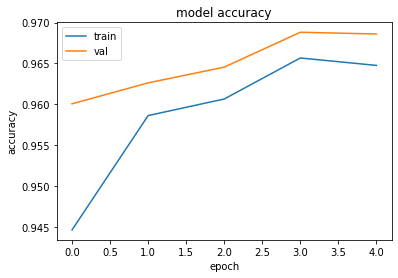

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [ ]:
network.save('network.h5')

In [ ]:
from keras.models import load_model

In [ ]:

from google.colab import files
conta_aero = files.upload()


In [ ]:
network = load_model('/content/network.h5')

In [ ]:
predict = network.predict(test_generator)

313/313 [==============================] - 75s 235ms/step


In [ ]:
test_df.loc[test_df.index == 0, 'filename'].values[0]

'Cat.11468.jpg'

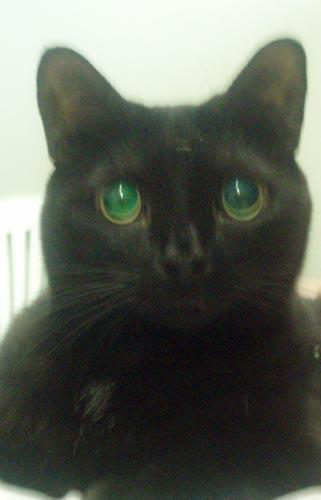

In [ ]:
image = load_img(f'/content/catsanddogs/{test_df.loc[test_df.index == 0, "filename"].values[0]}')
image

In [ ]:
pred  = []
for i in range(len(test_df)):
  samplefile,samplepredict = test_df[test_df.index == i].values[0]

  results={
      0:'cat',
      1:'dog'
  }
  im=Image.open(f'/content/catsanddogs/{samplefile}')
  im = im.convert("RGB")
  im=im.resize((128,128))
  im=np.expand_dims(im,axis=0)
  im=np.array(im)
  im=im/255
  pred.append(np.argmax(network.predict([im]),axis= -1))

In [ ]:
pred = np.array(pred)

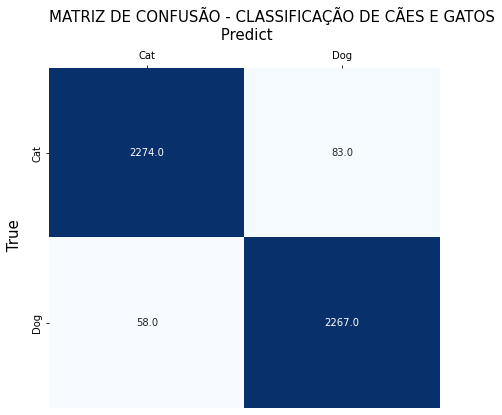

In [ ]:
import seaborn as sns


cm = confusion_matrix(test_generator.classes, pred)
# figure
fig, ax = plt.subplots(figsize=(7, 7))
# plot heatmap
sns.heatmap(cm, cmap="Blues",annot=True,fmt=".1f",cbar=False)
# xticks
ax.xaxis.tick_top()
xticks_labels = ['Cat', 'Dog']
plt.xticks(np.arange(2) + .5, labels=xticks_labels)

# yticks
ax.yaxis.tick_left()
yticks_labels = ['Cat', 'Dog']
plt.yticks(np.arange(2) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('')
plt.ylabel('')
# title
title = 'Matriz de confusão - Classificação de Cães e Gatos'.upper()
plt.xlabel(' Predict', labelpad= -380, fontsize=15)
plt.ylabel(' True', labelpad= 10, fontsize=15)
plt.subplots_adjust(top=0.8)
plt.title(title, loc='left', fontsize=15)
plt.show()

In [ ]:
test_df['category'] = test_df['category'].map({'Cat':0,'Dog':1})

In [ ]:
predictions = np.array(pred)

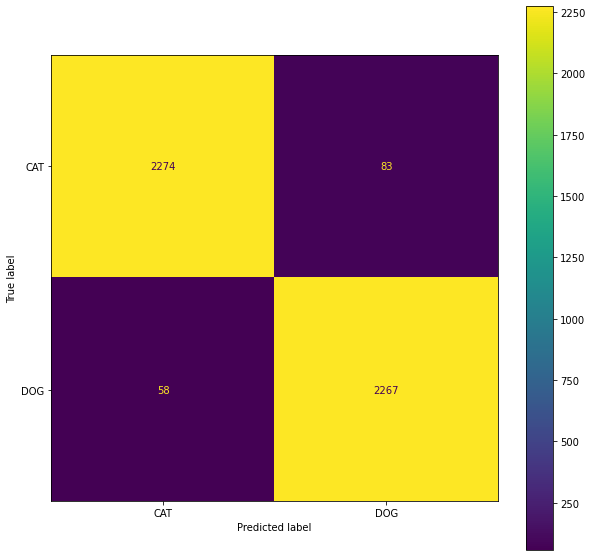

In [ ]:

cm = confusion_matrix(test_df['category'], predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['CAT', 'DOG'])


fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);


In [ ]:
print('f1_score')
print(f1_score(test_df['category'], predictions))
print('precision_score')
print(precision_score(test_df['category'], predictions))
print('recall_score')
print(recall_score(test_df['category'], predictions))
print('accuracy_score')
print(accuracy_score(test_df['category'], predictions))

f1_score
0.9698395721925134
precision_score
0.9646808510638298
recall_score
0.9750537634408603
accuracy_score
0.9698846646732165


Deploy do modelo:

[APP CACHORRO VS GATO](https://giuseppe31-s-geracao-tech-un-machine-learningappdogvscat-a4u22n.streamlit.app/)

🐶